# Lab 10 - Linear Models

In [1]:
% matplotlib inline

UsageError: Line magic function `%` not found.


## Directions

**Failure to follow the directions will result in a "0"**

The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN605.448@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import models
sns.set(style="whitegrid")

In [2]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})
    
def residual_plots(data, results, features, y):
    intercept = results['coefficients'][0]
    beta_1 = results['coefficients'][1]
    for feature in features:
        title = 'Residuals for {0} against {1}'.format(results['formula'], feature)
        scatter_plot_residuals(residuals=results['residuals'], X=data[feature], title=title)
        
def scatter_plot_residuals(residuals, title, X=None):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    
    # Simple scatter plot of the residuals
    if X is None:
        axes.plot(range(0, len(residuals)), residuals, 'o', color='steelblue', alpha=0.75)
    # Plot residuals against X
    else:
        axes.plot(X, residuals, 'o', color='steelblue', alpha=0.75)
        axes.set_xlabel('X')
    limits = max(np.abs(residuals.min()), residuals.max())
    axes.axhline(y=0.0, xmin=0, c='firebrick', alpha=0.5)
    axes.set_ylim((-limits, limits))
    axes.set_title(title)
    axes.set_ylabel('Residual')
    plt.show()
    plt.close()

# Answer

ETL

In [3]:
data = pd.read_csv('insurance.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [5]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


What do we think about variables and how they impact charges?

Age - Postive. Older the people, higher the charge

Sex - Positive. Male pays higher charge due to shorter life expectency

BMI - Positive. Higher BMI, higher the charge due to unhealthy condition

children - Positive. More children, higher the charges

Smoker - Positive. smoker means higher cost

region - ??

Adjust Dummy Variables

In [6]:
data = pd.concat([data, pd.get_dummies(data[['sex', 'smoker', 'region']])], axis = 'columns')
data.drop(['sex', 'smoker', 'region', 'smoker_no','sex_female'], axis='columns', inplace=True)
data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


Correlations

In [7]:
correlations(data, 'charges', ['age', 'smoker_yes', 'bmi', 'sex_male', 'region_southeast', 'region_southwest', 'region_northwest', 'children'])

,feature,r,rho
0,age,0.299008,0.534392
1,smoker_yes,0.787251,0.663460
2,bmi,0.198341,0.119396
3,sex_male,0.057292,0.009490
4,region_southeast,0.073982,0.017275
5,region_southwest,-0.043210,-0.042354
6,region_northwest,-0.039905,-0.021634
7,children,0.067998,0.133339


Based on the stats， age seems have non-linear relationship with rho than r Region doesn't seem to have significant relationships

Model

In [8]:
model = "charges ~ age + bmi + children + sex_male + smoker_yes"
result = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result)

We have a fairly good 75% R^2 which suggests 75% of variation in charges can be explained by the model. Negative intercept is hard to interpert. Age, bmi, children, smoker status all have positive impact on charges and strongly supported by the data.

Residual

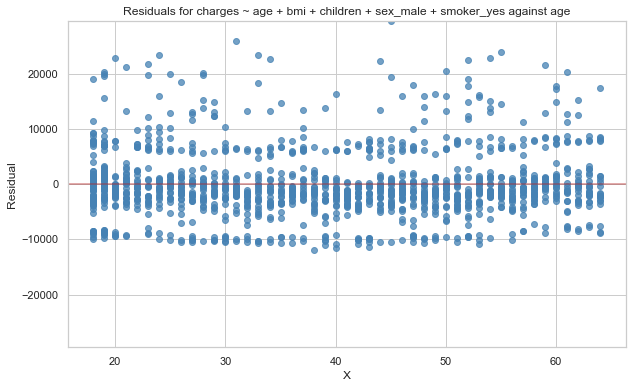

In [9]:
residual_plots(data, result, ['age'], 'charges')

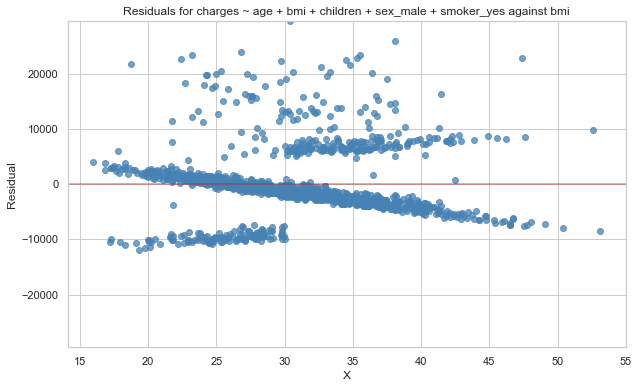

In [10]:
residual_plots(data, result, ['bmi'], 'charges')

Subgroups and patterns observed in the residual. Therefore, transformation is required to get rid of this.

Transformation

In [11]:
data["log_charges"] = np.log10(data.charges)

In [12]:
modellog = "log_charges ~ age + bmi + children + sex_male + smoker_yes"
resultlog = models.bootstrap_linear_regression(modellog, data=data)
models.describe_bootstrap_lr(resultlog)

Variables in the model2 follows the same impact as model 1 with adjusted R^2 76%

Residual

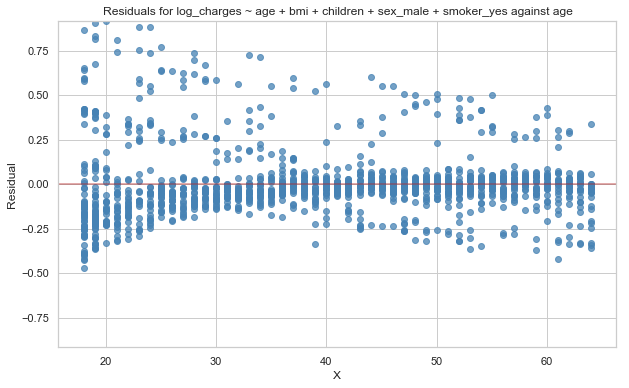

In [13]:
residual_plots(data, resultlog, ['age'], 'charges')

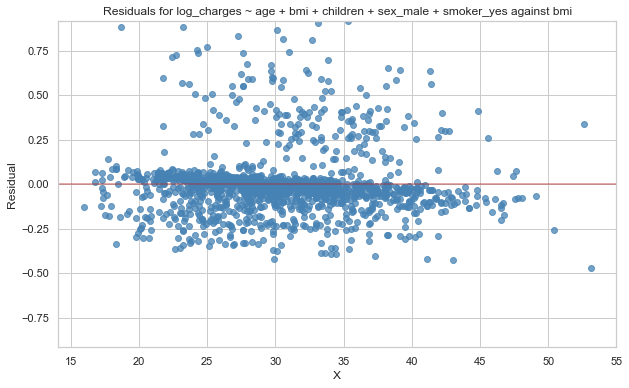

In [14]:
residual_plots(data, resultlog, ['bmi'], 'charges')

Errors are symmetric now. No more obvious pattern or subgroup observed.